In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import statsmodels.api as sample_data

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV




In [6]:
def metric_report(actual, predicted):
    acc_train = accuracy_score(actual, predicted)
    prec_train = precision_score(actual, predicted)
    rec_train = recall_score(actual, predicted)

    print("Accuracy : {:.4f}".format(acc_train))
    print("Precision: {:.4f}".format(prec_train))
    print("Recall.  : {:.4f}".format(rec_train))

In [7]:
def plot_roc(fpr, tpr, roc_auc, train):
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    if train == True:
        plt.title('Receiver Operating Characteristic for Train Data')
    else:
        plt.title('Receiver Operating Characteristic for Test Data')
    plt.legend(loc='lower right')
    plt.show()

# Load Data and check for missing values

In [8]:
# load the data into a pandas dataframe

data_path = r"C:\Users\trush\OneDrive\Documents\WFU Grad School Info\BAN 6025 Machine Learning\Data\Churn2-1 (1).csv"
df = pd.read_csv(data_path)

# preview data
df.info()
df.head
print(df)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   State           3333 non-null   object 
 1   Account Length  3333 non-null   int64  
 2   Area Code       3333 non-null   int64  
 3   Phone           3333 non-null   object 
 4   Int'l Plan      3333 non-null   object 
 5   VMail Plan      3333 non-null   object 
 6   VMail Message   3333 non-null   int64  
 7   Day Mins        3333 non-null   float64
 8   Day Calls       3333 non-null   int64  
 9   Day Charge      3333 non-null   float64
 10  Eve Mins        3333 non-null   float64
 11  Eve Calls       3333 non-null   int64  
 12  Eve Charge      3333 non-null   float64
 13  Night Mins      3333 non-null   float64
 14  Night Calls     3333 non-null   int64  
 15  Night Charge    3333 non-null   float64
 16  Intl Mins       3333 non-null   float64
 17  Intl Calls      3333 non-null   i

In [9]:
# total count of NaN values
print(df.isnull().sum())

State             0
Account Length    0
Area Code         0
Phone             0
Int'l Plan        0
VMail Plan        0
VMail Message     0
Day Mins          0
Day Calls         0
Day Charge        0
Eve Mins          0
Eve Calls         0
Eve Charge        0
Night Mins        0
Night Calls       0
Night Charge      0
Intl Mins         0
Intl Calls        0
Intl Charge       0
CustServ Calls    0
Churn?            0
dtype: int64


# Preprocess Data


*   Drop unnecessary variables
*   Convert target to numeric




In [10]:
# drop unnecessary columns
df.drop(['State', 'Area Code', 'Phone'], axis=1, inplace=True)
# convert plan variables to numerical
df["Int'l Plan"] = df["Int'l Plan"].apply(lambda x: 1 if x == 'yes' else 0)
df['VMail Plan'] = df['VMail Plan'].apply(lambda x: 1 if x == 'yes' else 0)
# Convert response from an integer to a categorical variable
df['Churn?'] = df['Churn?'].astype('category')
df.head()



,Account Length,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,128,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,107,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,137,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,84,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,75,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0


# Split data into training and test sets

Before splitting
*   Separate X and y variables into separate data frames
*   Create dummy variables



In [11]:
# split the data into training and testing sets
X = df.drop(['Churn?'], axis=1)

y = df['Churn?']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train.info()
y_train.info()




<class 'pandas.core.frame.DataFrame'>
Index: 2333 entries, 2016 to 3174
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Account Length  2333 non-null   int64  
 1   Int'l Plan      2333 non-null   int64  
 2   VMail Plan      2333 non-null   int64  
 3   VMail Message   2333 non-null   int64  
 4   Day Mins        2333 non-null   float64
 5   Day Calls       2333 non-null   int64  
 6   Day Charge      2333 non-null   float64
 7   Eve Mins        2333 non-null   float64
 8   Eve Calls       2333 non-null   int64  
 9   Eve Charge      2333 non-null   float64
 10  Night Mins      2333 non-null   float64
 11  Night Calls     2333 non-null   int64  
 12  Night Charge    2333 non-null   float64
 13  Intl Mins       2333 non-null   float64
 14  Intl Calls      2333 non-null   int64  
 15  Intl Charge     2333 non-null   float64
 16  CustServ Calls  2333 non-null   int64  
dtypes: float64(8), int64(9)
memory usag

# Decision Tree  
We will use 3 parameters to control the growth of the tree

- **max_depth** determines the maximum number of levels for the tree.  Smaller values help to prevent overfitting.  Default value = None

- **min_samples_leaf** determines the minimum number of observations that must remain in a leaf.  If a split leaves fewer than this number of observations, the split cannot be performed.  Larger values help to prevent overfitting.  Default value = 1.

- **ccp_alpha** is the cost complexity parameter and can be used for post-pruning the tree to help prevent overfitting.  Default value = 0.  Larger values yield a smaller tree.

In [12]:
# create an instance of a decision tree classifier using default values

dt = DecisionTreeClassifier(max_depth = 25, min_samples_leaf=10, ccp_alpha = 0.001)

# fit the model to the training data
dt.fit(X_train, y_train)

# this code can be used to produce a textual representation of the tree if desired
#text_rep = tree.export_text(dt)
#print(text_rep)



DecisionTreeClassifier(ccp_alpha=0.001, max_depth=25, min_samples_leaf=10)

# Visualize Tree

# Make Predictions on the training and test data

In [13]:
# make predictions on the training and test data
y_pred_train = dt.predict(X_train)
y_pred_test = dt.predict(X_test)

y_prob_train = dt.predict_proba(X_train)
y_prob_test = dt.predict_proba(X_test)



## Assess Model on Training and Test data

In [14]:
## print the scores
print(" -- train set -- ")

metric_report(y_train, y_pred_train)

print("")

print(" -- test set -- ")

metric_report(y_test, y_pred_test)


 -- train set -- 
Accuracy : 0.9447
Precision: 0.8552
Recall.  : 0.7471

 -- test set -- 
Accuracy : 0.9460
Precision: 0.8346
Recall.  : 0.7762


#Generate a confusion matrix for the training and test data

In [15]:
# confusion matrix
conf_matrix = confusion_matrix(y_pred_train, y_train)
print(conf_matrix)

# Generate confusion matrix for test set
conf_matrix = confusion_matrix(y_pred_test, y_test)
print(conf_matrix)

[[1950   86]
 [  43  254]]
[[835  32]
 [ 22 111]]


#Generate ROC curves for training and test data

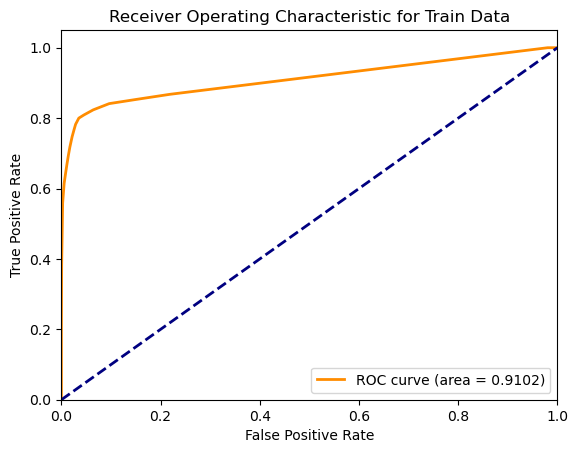

In [16]:
# Generate ROC curve for training data

fpr, tpr, thresholds = roc_curve(y_train.cat.codes, y_prob_train[:,1])
roc_auc = roc_auc_score(y_train.cat.codes, y_prob_train[:,1])

plot_roc(fpr, tpr, roc_auc, True)

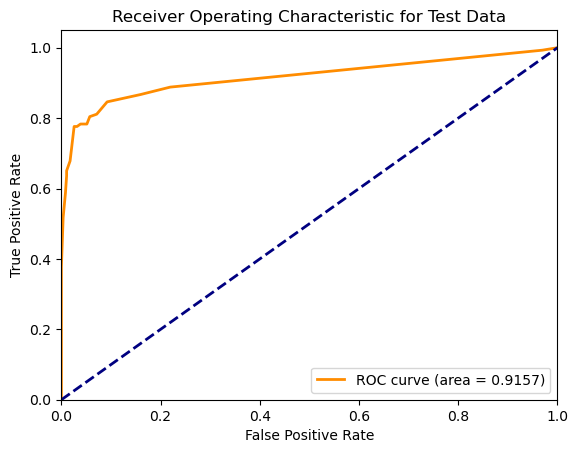

In [17]:
# Generate ROC curve for test data
fpr, tpr, thresholds = roc_curve(y_test.cat.codes, y_prob_test[:,1])
roc_auc = roc_auc_score(y_test.cat.codes, y_prob_test[:,1])

plot_roc(fpr, tpr, roc_auc, False)


#Print feature importance for the tree

    importance         feature
6     0.273196      Day Charge
16    0.153987  CustServ Calls
13    0.123363       Intl Mins
1     0.105190      Int'l Plan
14    0.084141      Intl Calls
7     0.068464        Eve Mins
9     0.068267      Eve Charge
2     0.061953      VMail Plan
4     0.037995        Day Mins
12    0.010734    Night Charge
11    0.006912     Night Calls
8     0.005798       Eve Calls
10    0.000000      Night Mins
5     0.000000       Day Calls
3     0.000000   VMail Message
15    0.000000     Intl Charge
0     0.000000  Account Length


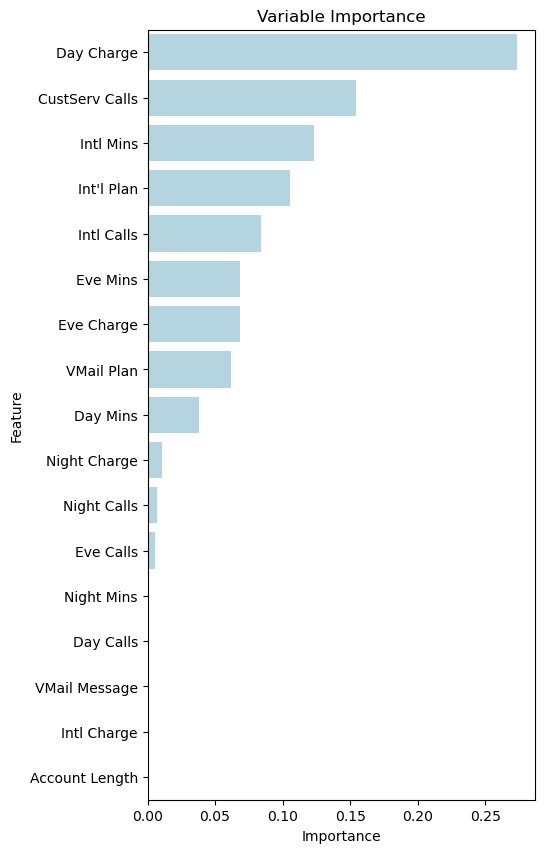

In [18]:
#calculate feature importance
tree_imp = dt.feature_importances_

#create a data frame with feature names

# creating a list of column names
column_values = ['importance']

# creating the dataframe
df = pd.DataFrame(data = tree_imp,
                  columns = column_values)
df['feature']=X.columns

#sort data so features with largest importance values are at the top
df2 = df.sort_values(by=['importance'], ascending=False)

print(df2)

#Create variable importance plot
plt.figure(figsize=(5, 10))
plt.title('Variable Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
sns.barplot(data=df2,
            y=df2['feature'],
            x=df2['importance'], color="lightblue")

plt.show()

#Tune Parameters of the Classification Tree

In [19]:
dt_tune = DecisionTreeClassifier()

param_grid = {
    'max_depth': [None, 5, 10, 15, 20, 25],
    'min_samples_leaf': [1, 10, 20, 50, 100],
    'ccp_alpha': [0, 0.001, 0.01, 0.1, 0.5, 1]
}

grid_search = GridSearchCV(dt_tune, param_grid, cv=5)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

print(best_params)
print(best_estimator)

{'ccp_alpha': 0.001, 'max_depth': 5, 'min_samples_leaf': 1}
DecisionTreeClassifier(ccp_alpha=0.001, max_depth=5)


#Score New Customers

Load new customer data into a data frame

In [20]:
# load the data into a pandas dataframe

data_path = r"C:\Users\trush\OneDrive\Documents\WFU Grad School Info\BAN 6025 Machine Learning\Data\NewChurnCustomers.csv"
dfnew = pd.read_csv(data_path)

# preview data
dfnew.info()
dfnew.head
print(dfnew)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   State           100 non-null    object 
 1   Account Length  100 non-null    int64  
 2   Area Code       100 non-null    int64  
 3   Phone           100 non-null    object 
 4   Int'l Plan      100 non-null    object 
 5   VMail Plan      100 non-null    object 
 6   VMail Message   100 non-null    int64  
 7   Day Mins        100 non-null    float64
 8   Day Calls       100 non-null    int64  
 9   Day Charge      100 non-null    float64
 10  Eve Mins        100 non-null    float64
 11  Eve Calls       100 non-null    int64  
 12  Eve Charge      100 non-null    float64
 13  Night Mins      100 non-null    float64
 14  Night Calls     100 non-null    int64  
 15  Night Charge    100 non-null    float64
 16  Intl Mins       100 non-null    float64
 17  Intl Calls      100 non-null    int6

Preprocess the new data so that it matches the structure of the data used to train the model

In [21]:
# drop unnecessary columns
dfnew.drop(['State', 'Area Code', 'Phone'], axis=1, inplace=True)
# convert plan variables to numerical
dfnew["Int'l Plan"] = dfnew["Int'l Plan"].apply(lambda x: 1 if x == 'yes' else 0)
dfnew['VMail Plan'] = dfnew['VMail Plan'].apply(lambda x: 1 if x == 'yes' else 0)
dfnew.head()



,Account Length,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls
0,59,0,0,0,179.4,80,30.50,232.5,99,19.76,175.8,105,7.91,14.7,3,3.97,0
1,165,0,0,0,207.7,109,35.31,164.8,94,14.01,54.5,91,2.45,7.9,3,2.13,0
2,133,0,0,0,277.3,138,47.14,228.4,117,19.41,117.3,103,5.28,12.8,4,3.46,2
3,140,0,0,0,125.3,84,21.30,167.6,121,14.25,260.6,94,11.73,8.4,4,2.27,1
4,93,0,1,32,138.1,91,23.48,167.3,72,14.22,238.9,115,10.75,6.8,3,1.84,2


"Score" the new data


In [22]:
# make predictions on the training and test data
Scored_class = dt.predict(dfnew)
Scored_probs = dt.predict_proba(dfnew)

dfnew['pred_Churn'] = Scored_class
dfnew['prod_prob_churn']=Scored_probs[:,1]

print(dfnew)

    Account Length  Int'l Plan  ...  pred_Churn  prod_prob_churn
0               59           0  ...           0         0.028791
1              165           0  ...           0         0.028791
2              133           0  ...           1         0.615385
3              140           0  ...           0         0.028791
4               93           0  ...           0         0.028791
..             ...         ...  ...         ...              ...
95             210           0  ...           0         0.028791
96             115           0  ...           0         0.035211
97             106           0  ...           1         0.984375
98              93           0  ...           0         0.028791
99              57           0  ...           0         0.116279

[100 rows x 19 columns]


In [43]:
import tensorflow as tf
from tensorflow.keras import layers, models

In [44]:
model = models.Sequential()

In [45]:
input_shape = (X.shape[1],)
model.add(layers.InputLayer(input_shape=input_shape))

c:\Users\trush\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [46]:
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(8, activation='relu'))

In [47]:
model.add(layers.Dense(1, activation='sigmoid'))

In [48]:
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['binary_accuracy'])

In [49]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 16)             │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 433 (1.69 KB)

 Trainable params: 433 (1.69 KB)

 Non-trainable params: 0 (0.00 B)

In [50]:
y_train = y_train.astype(float)
model.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - binary_accuracy: 0.1942 - loss: 22.1784
Epoch 2/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7635 - loss: 0.8801
Epoch 3/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8332 - loss: 0.7071
Epoch 4/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8518 - loss: 0.6504
Epoch 5/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8453 - loss: 0.6373 
Epoch 6/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.8541 - loss: 0.6101
Epoch 7/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8546 - loss: 0.5946
Epoch 8/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8744 - loss: 0.5715
Epoch 9/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8596 - loss: 0.5634
Epoch 10/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8616 - loss: 0.5495


In [51]:
y_test = y_test.astype(float)
model.evaluate(X_test, y_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8517 - loss: 0.5457  


[0.5431937575340271, 0.8569999933242798]